In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np
import seaborn as sns

In [151]:
#to do - ideas
#titles from names, binning ages, look more at cabin

In [136]:
df = pd.read_csv('train.csv')

In [137]:
# df.shape
df.info()
# df.head()
# df.isnull().sum(axis = 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [138]:
#Only 2 null embarked - we can drop these
#Cabin and Ticket I plan to look at later - for now I'm dropping them as they seem relatively unusable
df = df.drop(columns=['Cabin', 'Ticket'])
df = df.dropna(subset=['Embarked'])

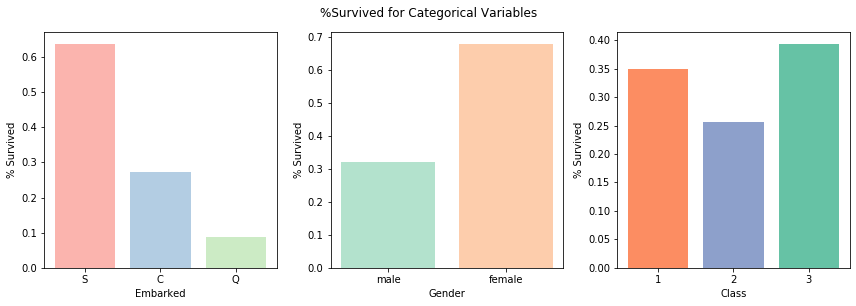

In [139]:
#View the relationship between categorical variables and %Survived
colorselect = np.arange(len(df))
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].set(xlabel='Embarked', ylabel='% Survived')
ax[0].bar(df.Embarked.unique(),
          df.Embarked[df.Survived == 1].value_counts(normalize=True),
          color=plt.cm.Pastel1(colorselect))
ax[1].set(xlabel='Gender', ylabel='% Survived')
ax[1].bar(df.Sex.unique(),
         df.Sex[df.Survived == 1].value_counts(normalize=True, sort=False),
         color=plt.cm.Pastel2(colorselect))
ax[2].set(xlabel='Class', ylabel='% Survived', xticks=[1, 2, 3])
ax[2].bar(pd.Categorical(df.Pclass).unique(),
            df.Pclass[df.Survived == 1].value_counts(normalize=True),
            color=plt.cm.Set2(colorselect))
fig.subplots_adjust(top=0.95)
pd.CategoricalIndex(df.Pclass.unique())
plt.suptitle('%Survived for Categorical Variables', y=1.05)
plt.tight_layout()
plt.show()

In [140]:
#Numerical encoding for Sex and Embarked
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['BinaryGender'] = enc.fit_transform(df.Sex)
df['EncEmbarked'] = enc.fit_transform(df.Embarked)

In [141]:
#OneHotEncoding for Embarked
df.Embarked = pd.Categorical(df.Embarked)
dfDummies = pd.get_dummies(df.Embarked).add_prefix('Embarked_')
df = pd.concat([df, dfDummies], axis=1)

In [142]:
# impute age data
from fancyimpute import KNN
data = df[['Pclass', 'Survived', 'Age', 'SibSp', 'Parch', 'BinaryGender', 'EncEmbarked']]
KNN_impute = KNN(k=2).fit_transform(data)[:, 2]
null_index = df[df['Age'].isnull()].index.tolist()
pd.options.mode.chained_assignment = None
df['Age'][null_index] = KNN_impute[null_index]
df['Age'] = df['Age'].astype(int)

Imputing row 1/889 with 0 missing, elapsed time: 0.095
Imputing row 101/889 with 1 missing, elapsed time: 0.096
Imputing row 201/889 with 1 missing, elapsed time: 0.098
Imputing row 301/889 with 1 missing, elapsed time: 0.099
Imputing row 401/889 with 0 missing, elapsed time: 0.100
Imputing row 501/889 with 0 missing, elapsed time: 0.102
Imputing row 601/889 with 1 missing, elapsed time: 0.103
Imputing row 701/889 with 0 missing, elapsed time: 0.104
Imputing row 801/889 with 0 missing, elapsed time: 0.105


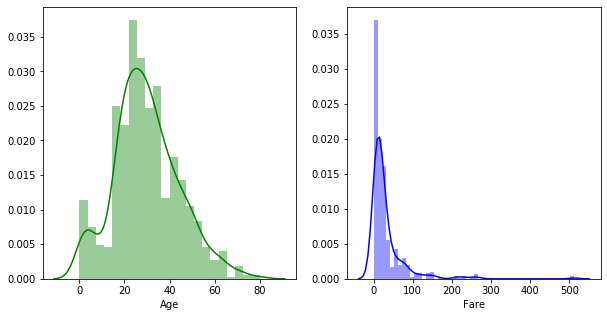

In [143]:
#Look at the distributions of Age and Fare - decide whether or not we want to normalize/standardize based on these
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))
sns.distplot(df['Age'], ax = ax[0], color = 'g')
sns.distplot(df['Fare'], ax = ax[1], color = 'b')

In [144]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
st = df[['Age', 'Fare']]
stan_data = StandardScaler().fit_transform(st)
stan_data = pd.DataFrame(stan_data, columns=['st_age', 'st_fare'])
df = df.join(stan_data).dropna(subset=['st_age', 'st_fare'])

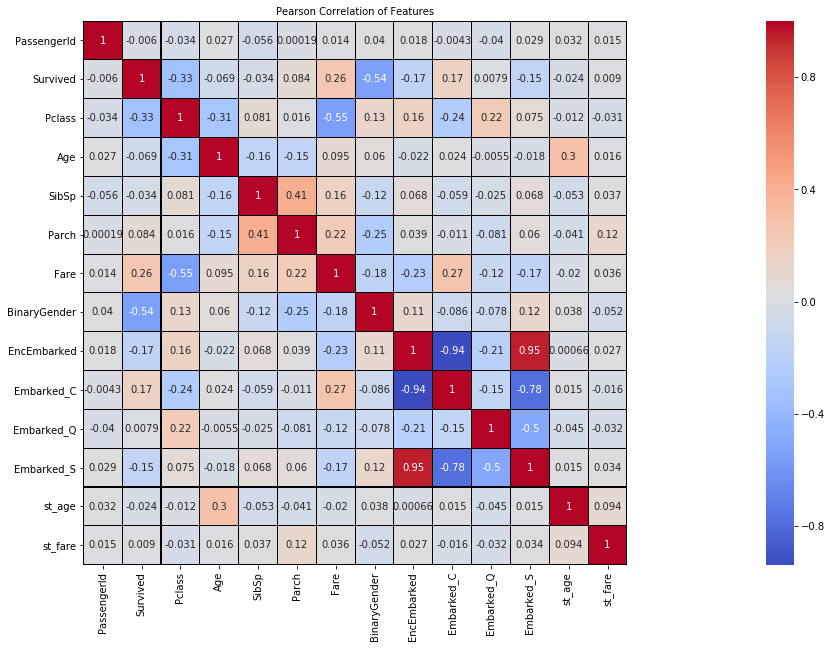

In [145]:
#Look at the correlations of all variables
colormap = plt.cm.coolwarm
plt.figure(figsize=(50,10))
plt.title('Pearson Correlation of Features', size=10)
sns.heatmap(df.corr(),linewidths=0.05,vmax=1.0, 
square=True, cmap=colormap, linecolor='black', annot=True)
plt.show()

In [146]:
#Drop columns that we don't want for training the data
df = df.drop(columns=['Name', 'Sex', 'Embarked', 'PassengerId'])
x = df.drop(columns='Survived')
y = df['Survived']

In [147]:
#determine significant variables using RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
x = df.drop(columns='Survived')
y = df['Survived']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [148]:
clf = RandomForestClassifier(n_estimators=100, random_state=50)
rfecv = RFECV(estimator=clf, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(x, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=50,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [149]:
#create a dataframe showing the key variables based on RFECV ranking
d = pd.DataFrame({'Feature': x.columns, 'Ranking': rfecv.ranking_}).sort_values(by='Ranking')
d = d[d['Ranking'] == 1]
d['Importance'] = rfecv.estimator_.feature_importances_ 
d.sort_values(by='Importance')

,Feature,Ranking,Importance
2,SibSp,1,0.043511
0,Pclass,1,0.086504
11,st_fare,1,0.138907
10,st_age,1,0.140371
1,Age,1,0.154694
4,Fare,1,0.183151
5,BinaryGender,1,0.252863


In [150]:
#train the model
from sklearn import metrics
trainx = df[d.Feature]
xtrain, xtest, ytrain, ytest = train_test_split(train, y, test_size=0.2)
clf2 = RandomForestClassifier(n_estimators=100)
clf2.fit(xtrain, ytrain)
ypred = clf2.predict(xtest)
metrics.accuracy_score(ytest, ypred)

0.8764044943820225